![sentiment_GE2019](sentiment_GE2019.png)

# Using Natural Language Processing on tweets to determine Likeability of parties during the 2019 General Election

Hi all, so in this blog post I'm going to take you through how to get started with the natural language processing of tweets using Twython, NLTK and TextBlob libaries. So first things first, if you havent got these libraries go ahead and pip install them. Open a terminal and type the below.

In [ ]:
pip install nltk
pip install twython
pip install textblob

For everything else I'm going to assume you have an Anaconda enviroment for python 3 already/are familiar with installing basic libraries such as numpy, matplotlib etc. If not you can find more information here:

https://www.anaconda.com/distribution/

Now the **2019 General Election** is getting closer with each day and there's no perfect way to get started with NLP than having a high volume of tweets that are full of opinionated people sharing their views on social media. What I'm going to show you is how you can produce plots like those above that show the cumulative likeability of UK parlimentary parties and their leaders. This also could work for reality TV shows, which politics is slowly morphing into... - see [Love Island Example](https://ibb.co/Dbv850p).

A bit of a disclaimer that what I'm about to show you is the very basics of NLP and that there are a **lot** of assumptions being made and so the results shown here should be taken with a huge pile of salt, but nevertheless if you're reading this wanting to learn new skills in python this is a good starting point. And who knows, maybe you could build upon these skills to make a better model come the next UK General Election, which seem to occur far too often now-a-days ;) .  

## Getting Started

Right, so lets get started. What I'm going to show you is how to parse through twitter information using twitters own API wrapper for python, and how to come up with some useful information using NLTK and pre-loaded sentiment values from TextBlob. 

You firstly need a twitter developer account, which can be made at:

https://developer.twitter.com/en/apply-for-access

This might take a while to be confirmed but once this is done you're good to go. The second thing you need to do is create an app by clicking on `Create an App`.

![Twitter developer app](twitter_dev.png)

You'll be asked lots of question mainly on the purpose of your project, but since we're doing this for educational purposes you can answer *No* to those that ask if you are going to display any tweet information. Once this is done you'll get a set of keys which you should store securely in a file named `keys.txt`. With the code in the cell below you can append the key information to an array and use this to configure access when calling `Twython`.

In [1]:
from twython import Twython
from nltk.corpus import stopwords
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from difflib import SequenceMatcher

mykeys = [] 

with open("keys.txt") as instream:
    for line in instream:
        mykeys.append(line)
        
twitterconsumerkey=mykeys[0].rstrip()
twitterconsumersecret=mykeys[1].rstrip()
twitteraccesskey=mykeys[2].rstrip()
twitteraccesssecret=mykeys[3].rstrip()

APP_KEY=twitterconsumerkey 
APP_SECRET=twitterconsumersecret
twitter=Twython(APP_KEY,APP_SECRET,oauth_version=2)
ACCESS_TOKEN = twitter.obtain_access_token()

twitter=Twython(APP_KEY,access_token=ACCESS_TOKEN)

Twython is a python wrapper for the Twitter API and quite easy to use since all that we are required to do is pass through the key information.

## Searching Tweets

Perfect, so now we have been through the technicalities we can start to grab information from tweets! Below is a function `searchtweets` which filters tweets using `twitter.search`. The arguments for this function are:

- What you want to query
- How many tweets you want to search
- Language
- The result type of the tweets; recent, popular or mixed.
- Minimum ID of tweet

More information on `twitter.search` can be found in the Twython documentation here:

https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets

Let's go through an example using one of my tweets I just wrote:

![An example tweet](example_tweet.png)


In [2]:
astring = "This is a test tweet for using the Twython function search #RandomHashtag"
language = "en"
result_type_str = "recent"
search_test = twitter.search(q=astring + '-filter:retweets',count=100,lang=language,result_type=result_type_str)

for result in search_test['statuses']:
    user=result.get("user",{})
    if user['screen_name'] == 'AdamJRuby':
        print(result.get("text",""))

This is a test tweet for using the Twython function search 

Testing testing testing testing #RandomHashtag


There we have it! We used the `.search` function to find a tweet in the twitter-verse. Obviously my search criteria was quite specific as I only wanted to return that particular tweet, but you can probably tell that we can get a lot more results if searching for hashtags.

More on the `searchtweets` function. You should notice that we need an input called `result_type`. This is the type of tweet you want to search for and can either be *popular*, *recent* or *mixed*. *popular* tweets are those that are considered popular by use of Twitters search algorithm and are usually the first tweets you see when you search a hashtag. *recent* tweets are just that, the most recent tweets to be posted. *mixed* is of course both. 

Twitter only allows us to take up to 100 tweets in a given search **BUT** there is a way around this [devil emoji]. We can set our `count` input to 100 (the max) and set our `max_id`, maximum tweet ID value for a given search, to the smallest tweet ID from our previous search and write a simple `for` loop. In our next iteration we search for the tweets below the smallest ID of our last search. I chose to a parameter I named `iteration` to search for tweets as a multiple of 100. We finally want to obtain a list containing all of the text from the tweets, which I creatively call `strings`.  

In [2]:
def searchtweets(astring,APP_KEY=twitterconsumerkey,APP_SECRET=twitterconsumersecret,count=100,language="en",iteration=3,result_type_str='recent'):
    #Safety to make sure we only use strings allowed for specific 'result_type's.
    result_type_list = ['recent','popular','mixed']
    if result_type_str not in result_type_list:
        return print("Please change result_type_list to either: 'recent', 'popular' or 'mixed'")
    
    #Total tweets we want to search
    numTweets = 0
    totalTweets = iteration*100
    
    #Access to the Twitter API (same as in first step)
    twitter=Twython(APP_KEY,APP_SECRET,oauth_version=2)
    ACCESS_TOKEN = twitter.obtain_access_token()
    twitter=Twython(APP_KEY,access_token=ACCESS_TOKEN)
    
    strings=[] #Initialise strings list
    min_id = 999999999999999999999999999999  #Ridiculous large number that an ID could possibly not be
    
    for i in range(0,iteration):
        #Search twitter, included -filter:retweets as we only want new tweets.
        mysearch=twitter.search(q=astring + '-filter:retweets',count=count,lang=language,result_type=result_type_str,max_id=min_id)
        for result in mysearch['statuses']:
            numTweets+=1
            strings.append(result.get("text",""))
            if int(result.get("id","")) < min_id:
                min_id = result.get("id","")
        #print(numTweets, " Completed out of potentially ", totalTweets, " in total")
    return strings

## Normalising Tweets

If you were to go through the individial strings saved from `searchtweets` you would find that it is a hot mess espeacially if we want to grab anything useful out of it. We need to normalise what we get first so that everything is comparable. We define our normalisation as so:

- Make all words lower case
- Get rid of stopwords
- Replace numbers with 'NUM'

Stopwords are words we all use that don't really add much to our search. We can get a list of stopwords by importing the `stopwords` function from the `nltk.corpus` module. I show the first 20 below.

In [33]:
stop = stopwords.words('english')
print(stop[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


More information on stopwords can be found here:

https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In the below cell is the function `normalise` which will do all of this for us.

In [3]:
def normalise(tokens):
    stop = stopwords.words('english')
    tokens=[token.lower() for token in tokens] #lowercase
    tokens=[token if token not in stop else "removethis" for token in tokens] #Get rid of stopwords
    count_remove = tokens.count('removethis')
    for i in range(0,count_remove):
        tokens.remove('removethis')
    tokens=[token if token != "removethis" else token for token in tokens]
    tokens=["NUM" if token.isdigit() else token for token in tokens] #Get rid of numbers
    return tokens

## Spam

On twitter, and social media in general, there are many times were spam becomes a problem. Spam, for those who don't know, is when someone/something posts the same thing over and over again to the same or many people in hope to achieve some goal. It's rare now that a person physically sends the same tweet over and over unless they have a lot of time on their hands so instead they programme a *bot* to do all of this automatically. These differ from re-tweets as they are literally different tweets but very very similar, since it's not the same exact tweet being shared. Election campaigns are renowned for a high volume of bot behvaiour and that's why we need to get rid of their involvement in our results.

To do this we want to use a module called `SequenceMatcher` from `difflib`. For two different strings it returns how similar they are as a fraction. We can create a function called `similar` to return only the information we need.

In [4]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [5]:
string1 = "My name is Adam and I don't like elections"
string2 = "My name is Adam and I love elections"
string3 = "The quick brown fox jumps over the lazy dog"

print("Similarity between string1 and string2: ", similar(string1,string2))
print("Similarity between string1 and string3: ", similar(string1,string3))

Similarity between string1 and string2:  0.8717948717948718
Similarity between string1 and string3:  0.21176470588235294


You can see from the example in the cell above how this works. Two strings that are very similar have a similarity value of 0.87 whereas two strings that are not that similar have a much lower value.

Now removing spam is a bit trickier and the code below is messy, but is the best I could come up with for now given the data. `remove_spam` has an input of the list of tweets and also a threshold for similarity. If two tweets have a similarity value over this threshold then they are removed from the dataset. Follow my comments in the code to see exactly what I did. This function for a large number of tweets is computationally expensive as we are comparing each tweet to all of the other tweets.

In [10]:
def remove_spam(tweets,threshold=0.7):
    print("Number of tweets before removing spam: ",len(tweets))
    
    thres_sim = threshold  #Similarity threshold

    for m in range(0,2):  #Run the below twice, just to be extra sure!
        spamindex_arr = []  #Need to keep a list of index of very similar tweets
        spamcounter_arr = [] #And a list of index of the tweet that's being compared
        for m in range(0,len(tweets)):
            spam=False
            tweet = ' '.join(tweets[m])   #Converts tweet (list) to tweet (string)

            if m%200 == 0:   #Just a print statement to keep us updated how many is left
                print("Completed ", m, " tweets out of a total ", len(tweets))

            #Loop through all tweets 
            for i in range(m,len(tweets)):
                if i != m:   #Don't want to compare tweet with itself
                    sim = float(similar(tweet,' '.join(tweets[i])))   #Similarity value
                    if sim > thres_sim:  #If statement to check if similarity value is over threshold
                        spamindex_arr.append(i)  #We append index to spamindex_arr if so.
                        spam=True
            if spam:   #Also need to append original tweet index to spancounter_arr
                spamcounter_arr.append(m)

        #Put both index arrays together
        spamindex_arr+=spamcounter_arr          
        for j in spamindex_arr:
            try:    #We will have duplicate index values in our array so need to mitigate the IndexError.
                tweets.pop(j) #Use list function pop to remove tweet from list tweets.
            except IndexError:
                continue  
    
        
    print("Completed removing spam")
    print("Number of tweets after removing spam: ",len(tweets))
    return tweets

Unfortunately, most of our dataset will be made up of spam, this is just a consequence of a general election post year 2005. Lets try it for approximately 1000 recent tweets using the search term *Corbyn #GeneralElection2019*.

In [52]:
nTweets = 1000
result_type_search = 'recent'
iter_tweets = int(nTweets/100)  #Since max tweet search is 100

topic_search = searchtweets("Corbyn #GeneralElection2019",iteration=iter_tweets,result_type_str=result_type_search)
tweets = normalise(topic_search)  #Normalisation
tokens=[tweet.strip().split(' ') for tweet in tweets]  #Strips away any spaces, we don't care about these
tokens=remove_spam(tokens)   #Removes spam

Number of tweets before removing spam:  928
Completed  0  tweets out of a total  928
Completed  100  tweets out of a total  928
Completed  200  tweets out of a total  928
Completed  300  tweets out of a total  928
Completed  400  tweets out of a total  928
Completed  500  tweets out of a total  928
Completed  600  tweets out of a total  928
Completed  700  tweets out of a total  928
Completed  800  tweets out of a total  928
Completed  900  tweets out of a total  928
Completed  0  tweets out of a total  313
Completed  100  tweets out of a total  313
Completed  200  tweets out of a total  313
Completed  300  tweets out of a total  313
Completed removing spam
Number of tweets after removing spam:  216


We can see from the number of tweets in our samples before and after removing spam that over **76%** of our tweets were infact considered spam. This is quite a lot and reduces our dataset significantly. Seeing this you might be thinking that the trade off between a higher number of tweets and spam (at  0.7 similarity rate) might not be worth losing but after personally spending a lot of time going through many of these tweets qualitatively above this threshold, it's obvious that this needed to be done.

## Sentiment Analysis

Now that we have all the string information, cleaned to an extent, we can start to use `TextBlob` and their clever sentiment vaules, function `TextBlob(string).sentiment`. The output shows two values, the first being the polarity and the second the subjectivity. The polarity is the value representing how positive or negative a statement is and is within the range -1 (negative) and +1 (positive). The subjectivity is on a scale from 0 to 1 and represents whether or not the statement is more subjective, i.e personal opinion, or more objective, i.e factual. You can check out more about TextBlob here:

https://textblob.readthedocs.io/en/dev/quickstart.html

Look at the example I made below to clarify what I mean:


In [10]:
astring="Internet explorer is awful"
print(astring," : ",TextBlob(astring).sentiment)

print("  ")

astring="Firefox is enjoyable to use"
print(astring," : ",TextBlob(astring).sentiment)

Internet explorer is awful  :  Sentiment(polarity=-1.0, subjectivity=1.0)
  
Firefox is enjoyable to use  :  Sentiment(polarity=0.5, subjectivity=0.6)


Looks like TextBlob really doesn't rate Internet Explorer. Jokes aside, I now need to talk about one of the drawbacks of using this method. 

We will be using the polarity value only for our analysis. Because of this there is a catch. Of course we will get a somewhat postive polarity from a tweet that says good things about a party leader, but we could also get negative polarity if the words used have the opposite meaning, like sarcasm. Look at this example: 

In [18]:
print("Tweets that mention the word 'Corbyn'")

astring="Corbyn is brilliant. I think his policies are just what this country needs!"
print("Pro Corbyn #1: ",TextBlob(astring).sentiment)

print("  ")

astring="The Tories will ruin this country. Their Brexit plan will be awful for our economy. Corbyn is the only option"
print("Pro Corbyn #2: ",TextBlob(astring).sentiment)

Tweets that mention the word 'Corbyn'
Pro Corbyn #1:  Sentiment(polarity=1.0, subjectivity=1.0)
  
Pro Corbyn #2:  Sentiment(polarity=-0.5, subjectivity=1.0)


Both statements above are examples of possible pro-Corbyn tweets but one gives a postive polarity whereas the other gives a negative value. To counter this would require a lot of time spent on *cleaning the data*. This is the most important job for a data scientist in my opinion as the results are only as good as the quality of the input data. For someone involved in NLP (which I am not) this requires a phenomenal amount of knowledge on qualitively classifying a vast amount of text-based information before even starting with machine learning or other MVA techniques. 

So lets put this in bold, **the result from this tutorial needs is probably inaccurate due to the very little effort given to data preperation**. 

We use the function `tweet_sentiment` to aggregate the sentiment polarity for all of the tweets. The output, `tweet_sent` is a list containing the cumulative sentiment polarity up to a particular tweet in the twitter timeline. 

In [11]:
def tweet_sentiment(tweets):
    tweet_sent = []
    sent_old = 0
    for tweet in tweets:
        sentence_sent = 0
        tweet_str = ' '.join(tweet)
        sentence_sent = TextBlob(tweet_str).sentiment[0]
        tweet_sent.append(sent_old+sentence_sent)
        sent_old+=sentence_sent
    return tweet_sent

## Final Function

Perfect! We now have all of the tools to build the overall function, `tweet_sentiment_func`, which brings together all of the above functions in the order I explained them.

The only extra thing added here is a small function to get the closest integer value of a specified number of tweets. 

The output will be our y-axis values for a given twitter search.

In [12]:
def tweet_sentiment_func(search_str,result_type_search,nTweets = 100):
    if search_str == '':
        return print("Please include something to search")
    
    iter_tweets = int(nTweets/100)  #Since max tweet search is 100

    topic_search = searchtweets(search_str,iteration=iter_tweets,result_type_str=result_type_search)
    tweets = normalise(topic_search)
    tokens=[tweet.strip().split(' ') for tweet in tweets]
    tokens=remove_spam(tokens)
    sent = tweet_sentiment(tokens)
    print(search_str," Complete!")
    return sent 

## Results

### Boris v Corbyn

Now for the moment of truth. We want to see the cumulative likeability, which in this context just means cumulative sentiment polarity, for the two main party leaders; Boris Johnson and Jeremy Corbyn.

I chose to use a hashtag `#GeneralElection2019`, the most popular twitter hashtag of this election month, as I want tweets related to the prime minister candiates only and not say tweets related to Boris Becker's former tennis career or Corbyn Besson's new song for *Why Dont We* (I had to google 'famous' Corbyn's, I have no idea who he is either).

In [11]:
#Get sentiment of search terms
tweet_type = 'recent'
numTweets = 1000
boris_sent = tweet_sentiment_func('Boris #GeneralElection2019',tweet_type,nTweets=numTweets)
corbyn_sent = tweet_sentiment_func('Corbyn #GeneralElection2019',tweet_type,nTweets=numTweets)
print("Searches complete!")

Number of tweets before removing spam:  1000
Completed  0  tweets out of a total  1000
Completed  200  tweets out of a total  1000
Completed  400  tweets out of a total  1000
Completed  600  tweets out of a total  1000
Completed  800  tweets out of a total  1000
Completed  0  tweets out of a total  506
Completed  200  tweets out of a total  506
Completed  400  tweets out of a total  506
Completed removing spam
Number of tweets after removing spam:  372
Boris #GeneralElection2019  Complete!
Number of tweets before removing spam:  912
Completed  0  tweets out of a total  912
Completed  200  tweets out of a total  912
Completed  400  tweets out of a total  912
Completed  600  tweets out of a total  912
Completed  800  tweets out of a total  912
Completed  0  tweets out of a total  224
Completed  200  tweets out of a total  224
Completed removing spam
Number of tweets after removing spam:  146
Corbyn #GeneralElection2019  Complete!
Searches complete!


I chose a relatively large number of tweets, 1000, but it's unlikely to return a number this large, even for the result_type = *recent*, especially after we take spam into account. For Boris it looks like 65% were spam and for Corbyn this was 75% (22:05,09/12/2019). For *popular* there is a much lower number of tweets, which we will get onto a bit later.

The cell below shows how we can plot the data. We use the modules `matplotlib` and `numpy` that we imported before. Remember to `pip install` like we did previously with any of the modules you haven't got.

Because of the search function the number of tweets might vary for both Boris and Corbyn so we need to find the length of the list with the minimum number of entries so it is a fair comparison. Our `x values` are given in `tweet_num` which is basically a list of integers in the range 0 to the minimum length of our sentiment arrays.

We also want to plot a line of best fit through the data to see the general trend. Looking at just the cumulative polarity only is very jaggered as we parse through larger bunches of positive and negative tweets in terms of sentiment using *stronger* language. For this, we use `numpy`'s `polyfit` function. The first two inputs here are the x values and y values. The third input is the degree for fitting the polynomial. We just want a straight line so we put this as `1`. See more on numpy's polyfit function in the documentation here:

https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html

The easiest way, and most scalable way, to plot a matplotlib 1D plot is to bunch all of the data into a `pandas` dataframe. For this we need to install and import `pandas` like at the start. The `pandas.DataFrame` function does all of the hard work and so all we have to do is input a python dictionary, giving the data suitable names such as `Corbyn fit` for the line of best fit describing Corbyn's data.

We plot each to a `matplotlib.pyplot` object using `plt.plot` and giving each a colour, line width and line style. See what else you can add and how to add it by looking at the documentation here:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html

We can also see the gradient values of the line of best fit by printing the value at the first index of our fit. We can conclude, at a stretch, that the larger this value is the more *likeable* a leader is for this sample of tweets. I've printed a timestamp for when this code was run for a particular plot.

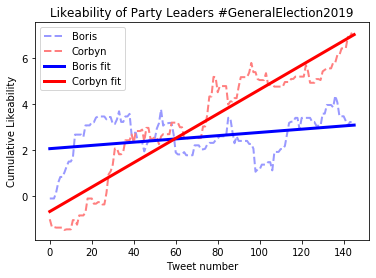

The Gradient values of the slopes: 
Boris:  0.007
Corbyn:  0.0528
 
Datetime:  2019-12-10 14:27:07.458352


In [12]:
#Plot the data
min_len = min(len(boris_sent),len(corbyn_sent))

tweet_num = list(range(0,min_len))
boris_sent = boris_sent[:min_len]
corbyn_sent = corbyn_sent[:min_len]

corbyn_fit = np.polyfit(tweet_num,corbyn_sent,1)
boris_fit = np.polyfit(tweet_num,boris_sent,1)

# Data
df=pd.DataFrame({'x': tweet_num, 'Boris': boris_sent, 'Corbyn': corbyn_sent, 
                 'Boris fit': np.polyval(boris_fit,tweet_num), 'Corbyn fit': np.polyval(corbyn_fit,tweet_num)})
    
    
# multiple line plot
plt.plot( 'x', 'Boris', data=df, marker='',color='#9999ff', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Corbyn', data=df, marker='', color='#ff7f7f', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Boris fit', data=df, marker='', color='blue', linewidth=3)
plt.plot( 'x', 'Corbyn fit', data=df, marker='', color='red', linewidth=3)
plt.legend()
plt.title('Likeability of Party Leaders #GeneralElection2019')
plt.ylabel('Cumulative Likeability')
plt.xlabel('Tweet number')
plt.savefig('GE'+'_recent_'+str(datetime.now())+'.png')
plt.show()

#Show the gradient values of the slops
print("The Gradient values of the slopes: ")
print("Boris: ",round(boris_fit[0],4))
print("Corbyn: ",round(corbyn_fit[0],4))
print(" ")
print("Datetime: ", datetime.now())

So again, without looking too much into what these results actually show because of reasons stated before we can still see that there is a trend.

For this particular plot we see that Corbyn's cumulative sentiment polarity reaches higher values after starting lower than that for Boris and has a gradient a factor of 7.5 larger. The sample size is very small, of only 146 tweets, so a larger sample size is very much needed over a longer period of time- but because of my `remove_spam` algorithm this would take hours!

We can look instead at what the *popular* tweets show, simply by changing our `result_type` variable to *popular*. What makes a tweet popular I do not know, a simple Google search didn't really help. But you get a feel for what popular tweets are by searching yourself on the app and seeing that the results you see are usually from verified accounts or have many retweets.

Lets try it out and see what results we get:

In [15]:
#Get sentiment of search terms
tweet_type = 'popular'
numTweets = 1000
boris_sent = tweet_sentiment_func('Boris #GeneralElection2019',tweet_type,nTweets=numTweets)
corbyn_sent = tweet_sentiment_func('Corbyn #GeneralElection2019',tweet_type,nTweets=numTweets)
print("Searches complete!")

Number of tweets before removing spam:  37
Completed  0  tweets out of a total  37
Completed  0  tweets out of a total  20
Completed removing spam
Number of tweets after removing spam:  16
Boris #GeneralElection2019  Complete!
Number of tweets before removing spam:  25
Completed  0  tweets out of a total  25
Completed  0  tweets out of a total  14
Completed removing spam
Number of tweets after removing spam:  14
Corbyn #GeneralElection2019  Complete!
Searches complete!


You can see that we only have a handfull of tweets passing spam, as there are only 25-37 popular tweets. Therefore the plot below wont tell us much since the volume of tweets is so small.

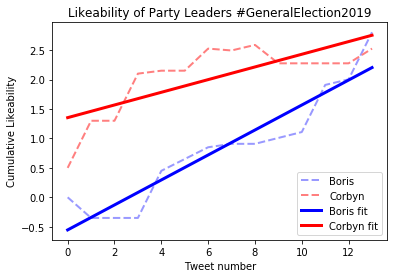

The Gradient values of the slopes: 
Boris:  0.212
Corbyn:  0.1076
 
Datetime:  2019-12-10 14:32:19.235704


In [16]:
#Plot the data
min_len = min(len(boris_sent),len(corbyn_sent))

tweet_num = list(range(0,min_len))
boris_sent = boris_sent[:min_len]
corbyn_sent = corbyn_sent[:min_len]

corbyn_fit = np.polyfit(tweet_num,corbyn_sent,1)
boris_fit = np.polyfit(tweet_num,boris_sent,1)

# Data
df=pd.DataFrame({'x': tweet_num, 'Boris': boris_sent, 'Corbyn': corbyn_sent, 
                 'Boris fit': np.polyval(boris_fit,tweet_num), 'Corbyn fit': np.polyval(corbyn_fit,tweet_num)})
    
    
# multiple line plot
plt.plot( 'x', 'Boris', data=df, marker='',color='#9999ff', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Corbyn', data=df, marker='', color='#ff7f7f', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Boris fit', data=df, marker='', color='blue', linewidth=3)
plt.plot( 'x', 'Corbyn fit', data=df, marker='', color='red', linewidth=3)
plt.legend()
plt.title('Likeability of Party Leaders #GeneralElection2019')
plt.ylabel('Cumulative Likeability')
plt.xlabel('Tweet number')
plt.savefig('GE'+'_recent_'+str(datetime.now())+'.png')
plt.show()

#Show the gradient values of the slops
print("The Gradient values of the slopes: ")
print("Boris: ",round(boris_fit[0],4))
print("Corbyn: ",round(corbyn_fit[0],4))
print(" ")
print("Datetime: ", datetime.now())

In contrast to the recent tweets plot, we now see that Boris' trend start at a negative value sentiment but has a gradient a factor of 2 larger than Corbyn's. To reiterate what I said before, the sample size is only 14 tweets so this is likely to show different results for a much larger sample. 


### Boris v Corbyn v Farage v Swinson 

What about if we added party leaders Nigel Farage of the Brexit party and Jo Swinson of the Lib Dems? (Sorry other parties, there's only so many labels that will fit on a plot without it being overcrowded!).

Number of tweets before removing spam:  1000
Completed  0  tweets out of a total  1000
Completed  200  tweets out of a total  1000
Completed  400  tweets out of a total  1000
Completed  600  tweets out of a total  1000
Completed  800  tweets out of a total  1000
Completed  0  tweets out of a total  701
Completed  200  tweets out of a total  701
Completed  400  tweets out of a total  701
Completed  600  tweets out of a total  701
Completed removing spam
Number of tweets after removing spam:  549
Boris #GeneralElection2019  Complete!
Number of tweets before removing spam:  907
Completed  0  tweets out of a total  907
Completed  200  tweets out of a total  907
Completed  400  tweets out of a total  907
Completed  600  tweets out of a total  907
Completed  800  tweets out of a total  907
Completed  0  tweets out of a total  507
Completed  200  tweets out of a total  507
Completed  400  tweets out of a total  507
Completed removing spam
Number of tweets after removing spam:  345
Corbyn #Gen

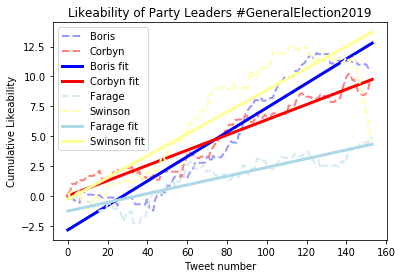

The Gradient values of the slopes: 
Boris:  0.1021
Corbyn:  0.0636
Farage:  0.0365
Swinson:  0.0914


In [14]:
#Get sentiment of search terms
tweet_type = 'recent'
numTweets = 1000
boris_sent = tweet_sentiment_func('Boris #GeneralElection2019',tweet_type,nTweets=numTweets)
corbyn_sent = tweet_sentiment_func('Corbyn #GeneralElection2019',tweet_type,nTweets=numTweets)
farage_sent = tweet_sentiment_func('Farage #GeneralElection2019',tweet_type,nTweets=numTweets)
swinson_sent = tweet_sentiment_func('Swinson #GeneralElection2019',tweet_type,nTweets=numTweets)
print("Searches complete!")

#Plot the data
min_len = min(len(boris_sent),len(corbyn_sent),len(farage_sent),len(swinson_sent))

tweet_num = list(range(0,min_len))
boris_sent = boris_sent[:min_len]
corbyn_sent = corbyn_sent[:min_len]
farage_sent = farage_sent[:min_len]
swinson_sent = swinson_sent[:min_len]

corbyn_fit = np.polyfit(tweet_num,corbyn_sent,1)
boris_fit = np.polyfit(tweet_num,boris_sent,1)
farage_fit = np.polyfit(tweet_num,farage_sent,1)
swinson_fit = np.polyfit(tweet_num,swinson_sent,1)

# Data
df=pd.DataFrame({'x': tweet_num, 'Boris': boris_sent, 'Corbyn': corbyn_sent, 'Farage': farage_sent, 'Swinson': swinson_sent,
                 'Boris fit': np.polyval(boris_fit,tweet_num), 'Corbyn fit': np.polyval(corbyn_fit,tweet_num),
                 'Farage fit': np.polyval(farage_fit,tweet_num), 'Swinson fit': np.polyval(swinson_fit,tweet_num)})
    
    
# multiple line plot
plt.plot( 'x', 'Boris', data=df, marker='',color='#9999ff', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Corbyn', data=df, marker='', color='#ff7f7f', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Boris fit', data=df, marker='', color='blue', linewidth=3)
plt.plot( 'x', 'Corbyn fit', data=df, marker='', color='red', linewidth=3)
plt.plot( 'x', 'Farage', data=df, marker='',color='#d4ebf2', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Swinson', data=df, marker='', color='#ffffad', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Farage fit', data=df, marker='', color='#add8e6', linewidth=3)
plt.plot( 'x', 'Swinson fit', data=df, marker='', color='#FFFF94', linewidth=3)
plt.legend()
plt.title('Likeability of Party Leaders #GeneralElection2019')
plt.ylabel('Cumulative Likeability')
plt.xlabel('Tweet number')
plt.savefig('GE_alleaders_'+str(datetime.now())+'.png')
plt.show()

#Show the gradient values of the slops
print("The Gradient values of the slopes: ")
print("Boris: ",round(boris_fit[0],4))
print("Corbyn: ",round(corbyn_fit[0],4))
print("Farage: ",round(farage_fit[0],4))
print("Swinson: ",round(swinson_fit[0],4))

Because of the lag in run time since my boris-corbyn plots (see timestamp) it looks as though Boris and Corbyn have switched places, this just shows how in just a few hours the sentiment towards one leader might change. It is not a suprise however that the Brexit party, that some may say have extreme views on many subjects, have the least cumulative postive sentiment value and the lowest gradient. 

### Conservatives v Labour v Brexit Party v Lib Dems


We can see how this compares with searching for the party names instead of just the leaders.

Number of tweets before removing spam:  998
Completed  0  tweets out of a total  998
Completed  200  tweets out of a total  998
Completed  400  tweets out of a total  998
Completed  600  tweets out of a total  998
Completed  800  tweets out of a total  998
Completed  0  tweets out of a total  733
Completed  200  tweets out of a total  733
Completed  400  tweets out of a total  733
Completed  600  tweets out of a total  733
Completed removing spam
Number of tweets after removing spam:  589
Conservative #GeneralElection2019  Complete!
Number of tweets before removing spam:  980
Completed  0  tweets out of a total  980
Completed  200  tweets out of a total  980
Completed  400  tweets out of a total  980
Completed  600  tweets out of a total  980
Completed  800  tweets out of a total  980
Completed  0  tweets out of a total  360
Completed  200  tweets out of a total  360
Completed removing spam
Number of tweets after removing spam:  222
Labour #GeneralElection2019  Complete!
Number of twee

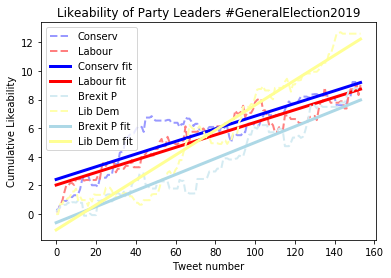

The Gradient values of the slopes: 
Conservatives:  0.0442
Labour:  0.0437
Brexit Party:  0.056
Lib Dems:  0.0871


In [15]:
#Get sentiment of search terms
tweet_type = 'recent'
numTweets = 1000
con_sent = tweet_sentiment_func('Conservative #GeneralElection2019',tweet_type,nTweets=numTweets)
lab_sent = tweet_sentiment_func('Labour #GeneralElection2019',tweet_type,nTweets=numTweets)
bre_sent = tweet_sentiment_func('Brexit Party #GeneralElection2019',tweet_type,nTweets=numTweets)
ld_sent = tweet_sentiment_func('Lib dems #GeneralElection2019',tweet_type,nTweets=numTweets)
print("Searches complete!")

#Plot the data
min_len = min(len(con_sent),len(lab_sent),len(bre_sent),len(ld_sent))

tweet_num = list(range(0,min_len))
con_sent = con_sent[:min_len]
lab_sent = lab_sent[:min_len]
bre_sent = bre_sent[:min_len]
ld_sent = ld_sent[:min_len]

lab_fit = np.polyfit(tweet_num,lab_sent,1)
con_fit = np.polyfit(tweet_num,con_sent,1)
bre_fit = np.polyfit(tweet_num,bre_sent,1)
ld_fit = np.polyfit(tweet_num,ld_sent,1)

# Data
df=pd.DataFrame({'x': tweet_num, 'Conserv': con_sent, 'Labour': lab_sent, 'Brexit P': bre_sent, 'Lib Dem': ld_sent,
                 'Conserv fit': np.polyval(con_fit,tweet_num), 'Labour fit': np.polyval(lab_fit,tweet_num),
                 'Brexit P fit': np.polyval(bre_fit,tweet_num), 'Lib Dem fit': np.polyval(ld_fit,tweet_num)})
    
    
# multiple line plot
plt.plot( 'x', 'Conserv', data=df, marker='',color='#9999ff', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Labour', data=df, marker='', color='#ff7f7f', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Conserv fit', data=df, marker='', color='blue', linewidth=3)
plt.plot( 'x', 'Labour fit', data=df, marker='', color='red', linewidth=3)
plt.plot( 'x', 'Brexit P', data=df, marker='',color='#d4ebf2', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Lib Dem', data=df, marker='', color='#ffffad', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Brexit P fit', data=df, marker='', color='#add8e6', linewidth=3)
plt.plot( 'x', 'Lib Dem fit', data=df, marker='', color='#FFFF94', linewidth=3)
plt.legend()
plt.title('Likeability of Party Leaders #GeneralElection2019')
plt.ylabel('Cumulative Likeability')
plt.xlabel('Tweet number')
plt.savefig('GE_allparties_'+str(datetime.now())+'.png')
plt.show()

#Show the gradient values of the slops
print("The Gradient values of the slopes: ")
print("Conservatives: ",round(con_fit[0],4))
print("Labour: ",round(lab_fit[0],4))
print("Brexit Party: ",round(bre_fit[0],4))
print("Lib Dems: ",round(ld_fit[0],4))

We can see that the trends stay rougly the same. This is what we suspect when associating a person with a particular party.


### Conservatives v Tories

And finally what about the use of language? For example, what is the different in sentiment for people that use *Conservatives* and *Tories*? 

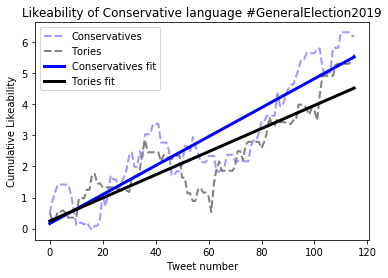

The Gradient values of the slopes: 
Conservatives:  0.0466
Tories:  0.0372
 
Datetime:  2019-12-10 22:53:45.658257


In [19]:
#Get sentiment of search terms
tweet_type = 'recent'
numTweets = 1000
conservatives_sent = tweet_sentiment_func('Conservatives #GeneralElection2019',tweet_type,nTweets=numTweets)
tories_sent = tweet_sentiment_func('Tories #GeneralElection2019',tweet_type,nTweets=numTweets)
print("Searches complete!")

#Plot the data
min_len = min(len(conservatives_sent),len(tories_sent))

tweet_num = list(range(0,min_len))
conservatives_sent = conservatives_sent[:min_len]
tories_sent = tories_sent[:min_len]

conservatives_fit = np.polyfit(tweet_num,conservatives_sent,1)
tories_fit = np.polyfit(tweet_num,tories_sent,1)

# Data
df=pd.DataFrame({'x': tweet_num, 'Conservatives': conservatives_sent, 'Tories': tories_sent, 
                 'Conservatives fit': np.polyval(conservatives_fit,tweet_num), 'Tories fit': np.polyval(tories_fit,tweet_num)})
    
    
# multiple line plot
plt.plot( 'x', 'Conservatives', data=df, marker='',color='#9999ff', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Tories', data=df, marker='', color='grey', linewidth=2, linestyle='dashed')
plt.plot( 'x', 'Conservatives fit', data=df, marker='', color='blue', linewidth=3)
plt.plot( 'x', 'Tories fit', data=df, marker='', color='black', linewidth=3)
plt.legend()
plt.title('Likeability of Conservative language #GeneralElection2019')
plt.ylabel('Cumulative Likeability')
plt.xlabel('Tweet number')
plt.savefig('GE'+'_torylang_'+str(datetime.now())+'.png')
plt.show()

#Show the gradient values of the slops
print("The Gradient values of the slopes: ")
print("Conservatives: ",round(conservatives_fit[0],4))
print("Tories: ",round(tories_fit[0],4))
print(" ")
print("Datetime: ", datetime.now())

Because Labour supporters are more likely to use the word *Tories* we can see it has a more negative sentiment compared to conservative supporters who are more likely to use the word *Conservatives*. Interesting, although by looking at the gradients they are not that far off, so maybe this is just chance.

## Thanks!

We've come to the end of the tutorial and I hope you learnt something new! Maybe you can build on these skills and come up with something better. Remember to not think too much into the results here as the data samples were always small and the assumptions in language were very lenient. But if you are able to please go out and vote on December 12th and have your say! 

A big thank you to the STFC Data Science Summer School 2019 at the University of Sussex, Brighton, for which the inspiration for this style of project came from. Special thanks to Julie Weeds from the University of Sussex for her help during her NLP course from the school in which a lot of this was based on. STFC fund a lot of data intensive schools like the one I attended and without their support I wouldn't have been to share with you my ideas. You can check out some of the projects we all took part in last July by searching the hashtage `#STFC_DI_AI_ML19` on Twitter.

## About me

My name is Adam Ruby, a experimental particle physics PhD Student at the University of Liverpool part of the ATLAS experiment. Funded by STFC (https://stfc.ukri.org/) and part of LIV.DAT (https://www.liverpool.ac.uk/livdat/).

Follow me on:
Twitter: @AdamJRuby
LinkedIn: https://www.linkedin.com/in/adam-ruby-487314140/

Thanks!